In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import ezodf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
%matplotlib inline

Function to import ODS

In [2]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})

Import dataset from https://www.gov.uk/government/publications/bovine-tb-historical-compensation-value-tables

In [3]:
df = read_ods("tbcompensation-commodity-prices-nov2019.ods", header=13)

Remove unneeded columns

In [4]:
df = df[['Month', 'Bull 24 months and over']]
df['Month'] = pd.to_datetime(df['Month'])
df.drop(df.tail(2).index,inplace=True)
print('shape: ' + str(df.shape))
print(df.tail(50))

shape: (165, 2)
         Month  Bull 24 months and over
115 2015-10-01                   2466.0
116 2015-11-01                   2452.0
117 2015-12-01                   2171.0
118 2016-01-01                   1994.0
119 2016-02-01                   2013.0
120 2016-03-01                   2180.0
121 2016-04-01                   2229.0
122 2016-05-01                   2183.0
123 2016-06-01                   2363.0
124 2016-07-01                   2433.0
125 2016-08-01                   2391.0
126 2016-09-19                   2314.0
127 2016-10-20                   2246.0
128 2016-11-19                   2287.0
129 2016-12-20                   2102.0
130 2017-01-18                   1912.0
131 2017-02-19                   1930.0
132 2017-03-22                   2182.0
133 2017-04-19                   2350.0
134 2017-05-20                   2402.0
135 2017-06-19                   2778.0
136 2017-07-20                   2741.0
137 2017-08-19                   2699.0
138 2017-09-19          

Plot 'Bull 24 months and over' data

[]

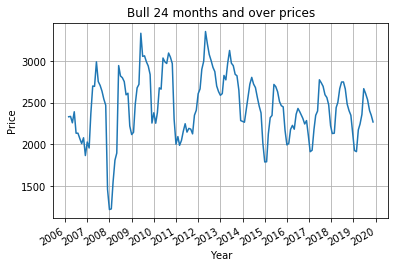

In [5]:
register_matplotlib_converters()
fig, ax = plt.subplots()
ax.plot('Month', 'Bull 24 months and over', data=df)
ax.xaxis_date()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Bull 24 months and over prices')
ax.set_ylabel('Price')
ax.set_xlabel('Year')
plt.grid()
plt.plot()

Split and normalize data

In [6]:
data = df['Bull 24 months and over'].values.astype(float)
test_size = 45
train_data = data[:-test_size]
test_data = data[-test_size:]
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [7]:
print(train_data_normalized)

[[0.52123192]
 [0.52309846]
 [0.48716752]
 [0.54923005]
 [0.42883808]
 [0.42883808]
 [0.39804013]
 [0.37050863]
 [0.40317312]
 [0.30331311]
 [0.37937471]
 [0.34577695]
 [0.53849743]
 [0.69388707]
 [0.69202053]
 [0.82967802]
 [0.71908539]
 [0.69715352]
 [0.66448903]
 [0.62015866]
 [0.58609426]
 [0.11339244]
 [0.        ]
 [0.00373308]
 [0.15445637]
 [0.27718152]
 [0.31731218]
 [0.80867942]
 [0.75034998]
 [0.74055063]
 [0.71861876]
 [0.64442371]
 [0.65328978]
 [0.46943537]
 [0.42137191]
 [0.43397107]
 [0.59122725]
 [0.68362109]
 [0.70321979]
 [0.99020065]
 [0.86047597]
 [0.86327578]
 [0.82967802]
 [0.80634624]
 [0.75828278]
 [0.48576762]
 [0.54363042]
 [0.48483434]
 [0.54503033]
 [0.68362109]
 [0.67615492]
 [0.85114326]
 [0.83014466]
 [0.82034531]
 [0.87914139]
 [0.85580961]
 [0.81987867]
 [0.50816612]
 [0.36724218]
 [0.40970602]
 [0.36070929]
 [0.38824078]
 [0.4395707 ]
 [0.48203453]
 [0.43490434]
 [0.45590294]
 [0.45170322]
 [0.42510499]
 [0.53009799]
 [0.55762949]
 [0.65048997]
 [0.67

Create float tensor.

In [8]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

Create function to group data in 12 month sequences

In [9]:
def to_year_sequence(data):
    seq = []
    L = len(data)
    for i in range(L-12):
        train_seq = data[i:i+12]
        train_label = data[i+12:i+12+1]
        seq.append((train_seq ,train_label))
    return seq

In [10]:
seq_data = to_year_sequence(train_data_normalized)

Create Model

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_layer_size
        self.hidden_cell = self.init_hidden()
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

assign MSE loss function and AMSGRAD optimizer as we dont have a lot of train data

In [12]:
model=LSTM()
loss = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

training models, 1500 epoch as we using small learning rate, but AMSGRAD optimizer and dataset size make training quite quick.

In [13]:
epochs = 1500

for i in range(epochs):
    for seq, labels in seq_data:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        y_pred = model(seq)

        single_loss = loss(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%100 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00992088
epoch: 101 loss: 0.00017267
epoch: 201 loss: 0.00118696
epoch: 301 loss: 0.00047896
epoch: 401 loss: 0.00000672
epoch: 501 loss: 0.00006863
epoch: 601 loss: 0.00000000
epoch: 701 loss: 0.00030988
epoch: 801 loss: 0.00000006
epoch: 901 loss: 0.00000000
epoch: 1001 loss: 0.00000000
epoch: 1101 loss: 0.00000000
epoch: 1201 loss: 0.00000000
epoch: 1301 loss: 0.00000000
epoch: 1401 loss: 0.00000000
epoch: 1499 loss: 0.0000000000


Prepare data to predict last 12 months

In [14]:
pred = 12

test_inputs = train_data_normalized[-12:].tolist()
print(test_inputs)

[0.42417171597480774, 0.5160989165306091, 0.5286980867385864, 0.7027531266212463, 0.6906206011772156, 0.6616892218589783, 0.6066262125968933, 0.5832944512367249, 0.5767615437507629, 0.44563695788383484, 0.3630424737930298, 0.3719085454940796]


make predictions

In [15]:
model.eval()

for i in range(pred):
    seq = torch.FloatTensor(test_inputs[-12:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        test_inputs.append(model(seq).item())

Print normalized predictions

In [16]:
test_inputs[pred:]

[0.5035097599029541,
 0.5142848491668701,
 0.718795120716095,
 0.7195456027984619,
 0.6769477128982544,
 0.7499633431434631,
 0.7322495579719543,
 0.7452636361122131,
 0.4698653221130371,
 0.37133729457855225,
 0.3541511297225952,
 0.35320380330085754]

Get actual predictions

In [17]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[12:] ).reshape(-1, 1))
actual_predictions = np.flip(actual_predictions, 0)

Create labaled predictions dataframe

In [18]:
df_pred_labels = df['Month'][-12:].reset_index(drop=True).to_frame()
df_pred = df_pred_labels.join(pd.DataFrame(actual_predictions))
df_pred.rename(columns={0:'Bull 24 months and over prediction'}, inplace=True)
print(df_pred)

        Month  Bull 24 months and over prediction
0  2018-12-20                         1972.915750
1  2019-01-17                         1974.945871
2  2019-02-19                         2011.775822
3  2019-03-22                         2222.921385
4  2019-04-19                         2813.099972
5  2019-05-20                         2785.210803
6  2019-06-19                         2823.171444
7  2019-07-19                         2666.698949
8  2019-08-21                         2757.986227
9  2019-09-23                         2756.377944
10 2019-10-20                         2318.112432
11 2019-11-19                         2295.021415


Plot the data to compare Bull 24 months and over prices(blue) with model price prediction (yellow)

[]

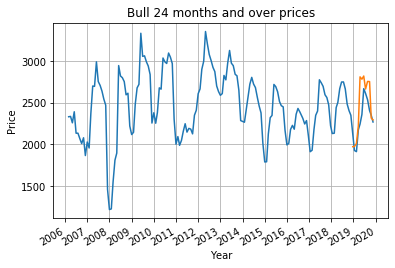

In [19]:
fig, ax = plt.subplots()
ax.plot('Month', 'Bull 24 months and over', data=df)
ax.plot('Month', 'Bull 24 months and over prediction', data=df_pred)
ax.xaxis_date()
fig.autofmt_xdate()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_title('Bull 24 months and over prices')
ax.set_ylabel('Price')
ax.set_xlabel('Year')
plt.grid()
plt.plot()

# Summary

I have used LSTM model, in my opinion is the best for sequential problems.

LSTM can obtain reasonable predictions in short period of time. I run it on CPU (6th gen i5) but probably you can get better results using GPU.

It can be improved by adding CNN and correlations between data. (eg. https://www.gov.uk/government/statistical-data-sets/livestock-prices-finished-and-store)